In [2]:
# Manejo de archivos
import os
from pathlib import Path

# Manejo de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

#outliers 
from pyod.models.mcd import MCD

from datetime import datetime, timedelta, time, date

# Quitar outliers

In [3]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
raw_folder = Path.cwd().parent / 'data' / 'raw'

In [4]:
df_raw = pd.read_parquet(raw_folder / "df_model.parquet")
df_vel_fixed =  df_raw[df_raw.velocidad >74.22].copy() #40% de los datos estan por encima del 74.22 y 77

In [5]:
mcd_model = MCD(contamination  = 0.01) #se probaron entre 0.1 y 0.5
vars_outliers = ['velocidad',
                'potencia',
                'flujo_agua',
                'rendimiento',
                'presion_ewm']
mcd_model.fit(df_raw[vars_outliers])
df_raw['outlier'] = mcd_model.labels_
df_vel_fixed['outlier'] = df_raw['outlier'] #funciona por ser indice datetime

<Axes: xlabel='presion_ewm', ylabel='potencia'>

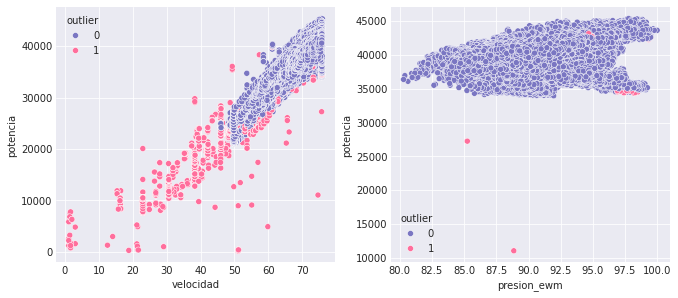

In [6]:
fig, axs = plt.subplots(1, 2, figsize = (11, 4.7))
sns.scatterplot(x = 'velocidad',
              y = 'potencia',
                hue = 'outlier',
             data = df_raw,
               ax = axs[0])

sns.scatterplot(x = 'presion_ewm',
              y = 'potencia',
             hue = 'outlier',
             data = df_vel_fixed,
               ax = axs[1])

In [14]:
df_clean = df_raw[df_raw["outlier"] == False]
df = df_clean.copy()
df.shape

(219553, 29)

# Transformar datos a intervalo

In [15]:
df.isna().sum()

velocidad         0
potencia          0
per_solidos       0
celda_carga       0
rendimiento       0
flujo_agua        0
ruido             0
p80               0
in14              0
in12              0
in10              0
in8               0
in6               0
in4               0
in3               0
in2_5             0
in2               0
in1_5             0
in1               0
f80               0
dureza            0
wi                0
spi               0
imp_criticos      0
imp_estandares    0
jb                0
presion_avg       0
presion_ewm       0
outlier           0
dtype: int64

In [16]:
df.columns

Index(['velocidad', 'potencia', 'per_solidos', 'celda_carga', 'rendimiento',
       'flujo_agua', 'ruido', 'p80', 'in14', 'in12', 'in10', 'in8', 'in6',
       'in4', 'in3', 'in2_5', 'in2', 'in1_5', 'in1', 'f80', 'dureza', 'wi',
       'spi', 'imp_criticos', 'imp_estandares', 'jb', 'presion_avg',
       'presion_ewm', 'outlier'],
      dtype='object')

In [18]:
#los datos con separación de 20 y 30 segundos se llenenan con un forward fill
df = df.asfreq('10s')
df = df.ffill(limit = 3) #rellenar a lo máximo 30 segundos
df.shape

(259201, 29)

In [19]:
#es de esperar que aumente los datos perdidos, los datos originales en lugar de tener
#nan simplemente omite el instante de tiempo en el indice
df.isna().sum() 

velocidad         7275
potencia          7275
per_solidos       7275
celda_carga       7275
rendimiento       7275
flujo_agua        7275
ruido             7275
p80               7275
in14              7275
in12              7275
in10              7275
in8               7275
in6               7275
in4               7275
in3               7275
in2_5             7275
in2               7275
in1_5             7275
in1               7275
f80               7275
dureza            7275
wi                7275
spi               7275
imp_criticos      7275
imp_estandares    7275
jb                7275
presion_avg       7275
presion_ewm       7275
outlier           7275
dtype: int64

In [20]:
window_len = 8 * 6 #cada 1 equivale a 10 segundos
vel_column = df.velocidad.rolling(window = window_len).mean().values
pot_column = df.potencia.values
rendimiento_column = df.rendimiento.rolling(window = window_len).mean().values
ruido_column = df.ruido.values
p80_column = df.p80.rolling(window = window_len).mean().values
# in10_column = df.in10.rolling(window = window_len).mean().values
# in1_column = df.in1.rolling(window = window_len).mean().values
f80_column = df.f80.rolling(window = window_len).mean().values
per_solidos_column = df.per_solidos.rolling(window = window_len).mean().values
wi_column = df.wi.rolling(window = window_len).mean().values
spi_column = df.spi.rolling(window = window_len).mean().values
imp_criticos_column = df.imp_criticos.rolling(window = window_len).mean().values
imp_estandares_column = df.imp_estandares.rolling(window = window_len).mean().values
jb_column = df.jb.values
presion = df.presion_ewm.values

In [21]:
df_model = pd.DataFrame({ 'velocidad':vel_column, # promedio
                       'potencia':pot_column, # de instante
                       'rendimiento':rendimiento_column,#promedio
                       'ruido':ruido_column,  #de instante
                       'p80':p80_column, #promedio
                       # 'in10':in10_column, #promedio
                       #  'in1':in1_column, #promedio
                       'f80':f80_column, #promedio
                       'per_solidos':per_solidos_column, #promedio
                       'wi':wi_column, #promedio
                       'spi':spi_column, #promedio
                       'imp_criticos':imp_criticos_column, #instante
                       'imp_estandares':imp_estandares_column, #instante
                       'jb':jb_column, #instante
                       'presion':presion, # de instante
                                 }, index = df.index)
df_model.iloc[window_len:].describe()

,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
count,249615.000000,251878.000000,249615.000000,251878.000000,249615.000000,249615.000000,249615.000000,249615.000000,249615.000000,249615.000000,249615.000000,251878.000000,251878.000000
mean,69.949563,37123.216399,59.447706,10.226303,44.540187,38.811705,75.155112,91.972196,50.621240,2.079740,40.835276,45.090910,88.501529
std,6.281367,4317.418389,8.327482,5.343075,17.238755,13.597160,3.212761,11.862125,14.987473,2.467494,22.272307,29.578182,3.534832
min,48.266666,21125.088265,24.500046,0.000000,0.000000,10.528415,45.629517,0.000000,0.000000,0.000000,0.013417,1.238072,68.339688
25%,65.730415,34608.781377,55.776946,6.143677,31.130319,28.855107,73.738647,94.225297,43.714228,0.223551,21.563964,20.880240,86.214820
50%,72.194388,38318.227360,61.387809,10.416884,44.740149,37.034137,75.862996,94.916176,50.572251,1.207983,45.604020,33.523393,88.459702
75%,75.735470,40355.720826,64.913149,13.522542,55.344245,47.956705,77.686952,95.619150,58.419725,3.237449,59.565281,78.739604,90.862035
max,75.820134,45390.650079,75.371860,99.938629,100.000000,91.966382,81.595704,100.000000,100.000000,63.959815,91.597141,100.000000,100.000000


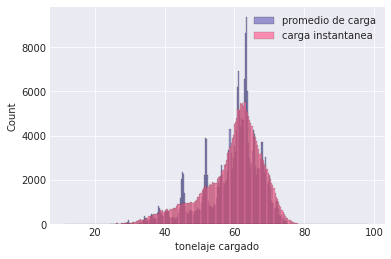

In [22]:
#diferencia entre tonelaje cargado instantaneo vs cada 8 minutos, se pierden las modas
ax = plt.gca()
sns.histplot(df_model.rendimiento,
             label = 'promedio de carga')
sns.histplot(df.rendimiento,
             label = 'carga instantanea')
ax.set_xlabel('tonelaje cargado')
ax.legend()